步骤1.1 导入数据

In [ ]:
import pandas as pd

# --- 参数配置 ---
# 使用相对路径，这样无论项目文件夹在哪里，代码都能正常工作
# '..' 表示从当前文件(preprocessing.ipynb)所在的scripts/目录，返回到上一级项目根目录
# 然后再进入 'data/' 目录找到文件
file_path = '../data/20250725_204056_20250718_JDL_report_Report..xlsx'

# 再次确认工作表的准确名称，这里假设之前的名称是正确的
sheet_to_read = '20250725_204056_20250718_JDL_re' 

print(f"正在尝试从相对路径读取文件: {file_path}")

# --- 数据读取与错误处理 ---
try:
    df = pd.read_excel(file_path, sheet_name=sheet_to_read)

    # 使用 f-string 格式化打印成功信息
    print(f"✅ 成功从文件的工作表 '{sheet_to_read}' 中导入数据！")
    print(f"数据维度（行, 列）: {df.shape}")
    
    # 在 Jupyter Notebook 中，使用 display() 可以获得更漂亮的表格输出
    display(df.head())

except FileNotFoundError:
    print(f"❌ 错误：文件未找到！")
    print(f"请再次检查相对路径是否正确: '{file_path}'")

except ValueError as e:
    print(f"❌ 错误：工作表名 '{sheet_to_read}' 不存在！")
    print("提示：请用 Excel 打开文件，确认工作表的准确名称。")

except Exception as e:
    print(f"❌ 发生了一个未知错误: {e}")

步骤1.2 数据清洗与过滤

步骤1.2.1 移除伪数据库匹配

In [ ]:
# 假设您已成功导入数据，并存放在名为 df 的 DataFrame 中

print("--- 开始数据清洗步骤 1.2.1: 移除伪数据库匹配 (Decoys) ---")

# 1. 查看过滤前的数据维度
print(f"原始数据维度 (行, 列): {df.shape}")

# 2. 查看 EG.IsDecoy 列的分布情况
# 这会告诉我们有多少是真实的(False)，有多少是诱饵(True)
print("\n过滤前 'EG.IsDecoy' 列的值分布：")
print(df['EG.IsDecoy'].value_counts())

# 3. 执行过滤操作
# 创建一个新的 DataFrame，只包含 'EG.IsDecoy' 为 False 的行。
# 加上 .copy() 是一个好习惯，可以避免后续操作出现警告，确保 df_no_decoys 是一个独立的副本。
df_no_decoys = df[df['EG.IsDecoy'] == False].copy()

# 4. 验证过滤结果
print("\n--- 过滤完成 ---")
print(f"移除 Decoy 后的数据维度 (行, 列): {df_no_decoys.shape}")

# 5. 再次检查 'EG.IsDecoy' 列，确认所有的 True 都已被移除
print("\n过滤后 'EG.IsDecoy' 列的值分布：")
# 如果操作成功，这里应该只会显示 False
print(df_no_decoys['EG.IsDecoy'].value_counts())

print("\n✅ Decoy 匹配已成功移除！")

步骤1.2.2 移除已知污染物

In [ ]:
# 假设 df_no_decoys 是上一步移除 Decoy 后得到的 DataFrame

print("\n--- 开始数据清洗步骤 1.2.2: 移除污染物 (Contaminants) ---")

# 1. 查看过滤前的数据维度
print(f"过滤前维度 (行, 列): {df_no_decoys.shape}")

# 2. 统计有多少行是污染物
# .str.startswith('CON__') 会返回一个布尔序列
# .sum() 会将 True (计为1) 和 False (计为0) 相加，从而得到污染物的总行数
contaminant_rows = df_no_decoys['PG.ProteinAccessions'].str.startswith('CON__', na=False).sum()
print(f"检测到 {contaminant_rows} 行数据属于污染物条目。")

# 3. 执行过滤操作
# 我们要保留所有 *不* 以 'CON__' 开头的行。
# 波浪号 '~' 在 Pandas 中代表 '取反' (NOT) 的操作。
# 同样，使用 .copy() 是一个好习惯。
df_no_contaminants = df_no_decoys[~df_no_decoys['PG.ProteinAccessions'].str.startswith('CON__', na=False)].copy()

# 4. 验证过滤结果
print("\n--- 过滤完成 ---")
print(f"移除污染物后的数据维度 (行, 列): {df_no_contaminants.shape}")

# 5. 再次检查，确认污染物已被移除
remaining_contaminants = df_no_contaminants['PG.ProteinAccessions'].str.startswith('CON__', na=False).sum()
print(f"过滤后剩余的污染物行数: {remaining_contaminants}") # 这个数字应该是 0

print("\n✅ 污染物条目已成功移除！")

步骤1.2.3 基于Q-value值进行过滤

In [ ]:
# 假设 df_no_contaminants 是上一步移除污染物后得到的 DataFrame

print("\n--- 开始数据清洗步骤 1.2.3: 基于 PG.Qvalue < 0.01 进行过滤 ---")

# 1. 查看过滤前的数据维度
print(f"过滤前维度 (行, 列): {df_no_contaminants.shape}")

# 2. 查看 PG.Qvalue 的分布情况（可选，但有助于理解数据）
# .describe() 可以给出该列的统计摘要，如均值、最大值、最小值、四分位数等
print("\n过滤前 'PG.Qvalue' 列的统计摘要：")
display(df_no_contaminants['PG.Qvalue'].describe())

# 3. 执行过滤操作
# 定义我们的阈值
QVALUE_THRESHOLD = 0.01

# 创建一个新的 DataFrame，只包含 'PG.Qvalue' 小于阈值的行。
# 同样，使用 .copy() 是一个好习惯。
df_filtered = df_no_contaminants[df_no_contaminants['PG.Qvalue'] < QVALUE_THRESHOLD].copy()

# 4. 验证过滤结果
print("\n--- 过滤完成 ---")
print(f"按 PG.Qvalue < {QVALUE_THRESHOLD} 过滤后的数据维度 (行, 列): {df_filtered.shape}")

# 5. 再次检查，确认所有保留的行的 PG.Qvalue 都符合标准
# 我们可以通过查看过滤后 PG.Qvalue 的最大值来验证
max_qvalue_after_filter = df_filtered['PG.Qvalue'].max()
print(f"过滤后 'PG.Qvalue' 的最大值: {max_qvalue_after_filter}") # 这个值应该小于 0.01

print("\n✅ 已成功按 Q-value 阈值进行过滤！")
print("🎉 阶段 1.2 的所有数据清洗与过滤任务已全部完成！")

步骤1.3 实验重复性检验

检查df_filtered数据是否可用

In [ ]:
# Cell 2: 准备要分析的数据
# 假设 df_filtered 是您在之前的步骤中，经过了去Decoy、去污染物、Q-value过滤后得到的最终数据集。

# 确认一下 df_filtered 是否存在且有数据
if 'df_filtered' in locals() and not df_filtered.empty:
    display(df_filtered.head())
    print(f"数据准备就绪！df_filtered 包含 {df_filtered.shape[0]} 行数据。")
else:
    print("❌ 错误：请先运行前面的数据清洗步骤，以生成 df_filtered 数据集！")

步骤1.3.1 蛋白质组和肽段数目重复性检验

（1）导入函数

In [ ]:
# ==========================================================
# assess_reproducibility (最终强力修复版 - 使用字体文件路径)
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib_venn import venn3, venn2
from matplotlib.font_manager import FontProperties

def assess_reproducibility(dataframe, 
                           run_col='R.FileName', 
                           protein_col='PG.ProteinGroups', 
                           peptide_col='PEP.StrippedSequence',
                           plot_title_prefix='',
                           draw_venn=True,
                           sample_whitelist=None,
                           language='ch'):
    
    # --- 0. 语言、标签、字体设置 ---
    default_labels = {
        'ch': { 'sample_name': '样本名称', 'protein_count': '蛋白组数量', 'peptide_count': '肽段数量', 'protein_bar_title': '各样本鉴定到的蛋白组数量', 'protein_bar_ylabel': '唯一蛋白组数量', 'peptide_bar_title': '各样本鉴定到的肽段数量', 'peptide_bar_ylabel': '唯一肽段数量', 'sample_label': '样本', 'venn_protein_title_3': '蛋白质组鉴定重叠情况 (3个样本)', 'venn_protein_title_2': '蛋白质组鉴定重叠情况 (2个样本)', 'summary_table_title': '统计摘要表：', 'venn_attempt_msg': '--- 正在尝试绘制韦恩图 ---', 'venn_skip_msg': '提示：样本数量为 {num_samples}，不适合绘制韦恩图。' },
        'en': { 'sample_name': 'Sample Name', 'protein_count': 'Protein Count', 'peptide_count': 'Peptide Count', 'protein_bar_title': 'Protein Groups Identified per Sample', 'protein_bar_ylabel': 'Unique Protein Groups', 'peptide_bar_title': 'Peptides Identified per Sample', 'peptide_bar_ylabel': 'Unique Peptides', 'sample_label': 'Sample', 'venn_protein_title_3': 'Protein Group Overlap (3 Samples)', 'venn_protein_title_2': 'Protein Group Overlap (2 Samples)', 'summary_table_title': 'Summary:', 'venn_attempt_msg': '--- Drawing Venn diagrams ---', 'venn_skip_msg': 'Info: {num_samples} samples, not suitable for Venn diagram.' }
    }
    current_labels = default_labels.get(language, default_labels['en'])
    
    my_font = None
    if language == 'ch':
        # 直接使用您系统中确认存在的字体文件路径
        font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'
        try:
            my_font = FontProperties(fname=font_path)
            print("✅ 成功加载中文字体文件。")
        except FileNotFoundError:
            print(f"❌ 警告：在 '{font_path}' 未找到中文字体，中文将无法显示。")
        plt.rcParams['axes.unicode_minus'] = False # 解决中文环境负号显示问题
    else:
        plt.rcParams['axes.unicode_minus'] = True # 英文环境恢复默认

    # --- 1. 数据筛选 ---
    if sample_whitelist:
        analysis_df = dataframe[dataframe[run_col].isin(sample_whitelist)].copy()
    else:
        analysis_df = dataframe.copy() 
        
    if analysis_df.empty:
        print("❌ 错误：筛选后无数据可分析。")
        return None
    
    # --- 2. 统计计算 ---
    protein_sets, peptide_sets = {}, {}
    summary_agg = analysis_df.groupby(run_col).agg(
        protein_count=(protein_col, 'nunique'),
        peptide_count=(peptide_col, 'nunique'),
        protein_set=(protein_col, lambda x: set(x.unique())),
        peptide_set=(peptide_col, lambda x: set(x.unique()))
    )
    for idx, row in summary_agg.iterrows():
        protein_sets[idx] = row['protein_set']
        peptide_sets[idx] = row['peptide_set']
    summary_stats = summary_agg[['protein_count', 'peptide_count']].reset_index()
    summary_stats = summary_stats.rename(columns={
        run_col: current_labels['sample_name'],
        'protein_count': current_labels['protein_count'],
        'peptide_count': current_labels['peptide_count']
    })
    print(f"\n{current_labels['summary_table_title']}")
    display(summary_stats)

    # --- 3. 绘图 ---
    sns.set_theme(style="whitegrid")
    
    # 蛋白组条形图
    plt.figure(figsize=(12, 6))
    ax1 = sns.barplot(data=summary_stats, x=current_labels['sample_name'], y=current_labels['protein_count'], palette='viridis', hue=current_labels['sample_name'], legend=False)
    ax1.set_title(f"{plot_title_prefix}{current_labels['protein_bar_title']}".strip(), fontproperties=my_font, fontsize=16)
    ax1.set_ylabel(current_labels['protein_bar_ylabel'], fontproperties=my_font, fontsize=12)
    ax1.set_xlabel(current_labels['sample_label'], fontproperties=my_font, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    # 为X轴刻度标签也应用字体
    if my_font:
        for label in ax1.get_xticklabels():
            label.set_fontproperties(my_font)
    for p in ax1.patches:
        ax1.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.tight_layout()
    plt.show()

    # 肽段条形图
    plt.figure(figsize=(12, 6))
    ax2 = sns.barplot(data=summary_stats, x=current_labels['sample_name'], y=current_labels['peptide_count'], palette='plasma', hue=current_labels['sample_name'], legend=False)
    ax2.set_title(f"{plot_title_prefix}{current_labels['peptide_bar_title']}".strip(), fontproperties=my_font, fontsize=16)
    ax2.set_ylabel(current_labels['peptide_bar_ylabel'], fontproperties=my_font, fontsize=12)
    ax2.set_xlabel(current_labels['sample_label'], fontproperties=my_font, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    if my_font:
        for label in ax2.get_xticklabels():
            label.set_fontproperties(my_font)
    for p in ax2.patches:
        ax2.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.tight_layout()
    plt.show()

    # 韦恩图
    if draw_venn:
        sample_names = list(protein_sets.keys())
        num_samples = len(sample_names)
        print(f"\n{current_labels['venn_attempt_msg']}")
        if num_samples == 3:
            plt.figure(figsize=(10, 8))
            venn_plot = venn3([protein_sets[s] for s in sample_names], set_labels=sample_names)
            title_text = f"{plot_title_prefix}{current_labels['venn_protein_title_3']}".strip()
            plt.title(title_text, fontproperties=my_font, fontsize=16)
            plt.show()
        elif num_samples == 2:
            plt.figure(figsize=(8, 6))
            venn_plot = venn2([protein_sets[s] for s in sample_names], set_labels=sample_names)
            title_text = f"{plot_title_prefix}{current_labels['venn_protein_title_2']}".strip()
            plt.title(title_text, fontproperties=my_font, fontsize=16)
            plt.show()
        else:
            print(current_labels['venn_skip_msg'].format(num_samples=num_samples))
            
    return summary_stats

（2）检查有多少个组别

In [ ]:
# ======================================================================
# Cell 2: 探索步骤 - 获取可用的样本名称
# ======================================================================

# 假设 df_filtered 是您已经清洗好的数据
all_available_samples = get_sample_names(df_filtered)

### 函数使用方法

本项目定义了两个核心的辅助函数：`get_sample_names` 和 `assess_reproducibility`。

#### 1. `get_sample_names` 函数

*   **功能**: 从一个数据框（DataFrame）中提取并列出所有唯一的样本名称，方便后续选择和分析。
*   **使用方法**:
    ```python
    # 假设 df_filtered 是您已经清洗好的数据
    all_available_samples = get_sample_names(df_filtered)
    ```
    运行后，它会打印出所有可用的样本名列表。

#### 2. `assess_reproducibility` 函数

*   **功能**:
    这是一个多功能的重复性评估工具，可以：
    1.  绘制所有样本或指定样本子集的ID计数**条形图 (Bar Plot)**。
    2.  当分析的样本数为2或3时，自动绘制**韦恩图 (Venn Diagram)** 来显示ID重叠情况。
*   **参数说明**:
    ```python
    def assess_reproducibility(dataframe, 
                               run_col='R.FileName', 
                               protein_col='PG.ProteinGroups', 
                               peptide_col='PEP.StrippedSequence',
                               plot_title_prefix='',
                               draw_venn=True,
                               sample_whitelist=None，
                               language='ch'):
    ```
    该函数有多个参数，但只有第一个参数 `dataframe` 是必需的（没有默认值），调用时必须提供。其他参数都有默认值，可以根据需要提供以覆盖默认行为。
    其中‘language’参数可选‘ch’和‘en’，对应两种不同语言，同时plot_title_prefix需要自己输入

*   **核心使用场景**:

    **(一) 查看所有样本的ID计数对比 (只输出条形图)**
    
    这是最简单的用法，只需提供必需的 `dataframe` 参数即可。
    ```python
    assess_reproducibility(dataframe=df_filtered, plot_title_prefix='全部样本')
    ```

    **(二) 查看特定组内的重复性 (输出条形图和韦恩图)**

    这通常需要两步：
    1.  首先，运行 `get_sample_names(df_filtered)` 查看所有可用的样本名。
    2.  然后，从输出中复制您感兴趣的样本名，创建一个列表（我们称之为“白名单”），并将其传入函数。

    **举例**:
    假设我们想分析以下三个重复样本：
    ```python
    # 创建一个包含目标样本名的Python列表
    group_a_whitelist = [
        'JDL_1_Slot2-10_1_20405',
        'JDL_2_Slot2-11_1_20406',
        'JDL_3_Slot2-12_1_20407'
    ]
    ```

    然后，将这个列表作为 `sample_whitelist` 参数传入函数：
    ```python
    summary_table = assess_reproducibility(
        dataframe=df_filtered,
        sample_whitelist=group_a_whitelist,
        plot_title_prefix='小鼠脑'
    )
    ```
    这样，函数就会只针对这三个样本进行分析和绘图。

（3）调用函数并查看结果

In [ ]:
# Cell 3: 调用函数进行分析

#定义白名单
group_a_whitelist = ['JDL_1_Slot2-10_1_20405',
                     'JDL_2_Slot2-11_1_20406',
                     'JDL_3_Slot2-12_1_20407'] 

# 调用我们自己定义的函数，把准备好的数据 df_filtered 传给它
summary_table = assess_reproducibility(dataframe=df_filtered, 
                                              sample_whitelist=group_a_whitelist,
                                              plot_title_prefix='小鼠脑',
                                              language='ch'
                                              )

步骤1.3.2 蛋白质组定量重复性检验

导入函数，包括构建定量矩阵、根据定量矩阵绘制热图、PCA图和定量箱线图

In [ ]:
# ====================================================================
# 函数: analyze_quantitative_reproducibility (最终强力修复版)
# ====================================================================
# 确保已安装必要的库
# !pip install pandas numpy matplotlib seaborn scikit-learn

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.font_manager import FontProperties # <-- 新增导入

def analyze_quantitative_reproducibility(dataframe,
                                         run_col='R.FileName',
                                         protein_col='PG.ProteinGroups',
                                         quantity_col='PG.Quantity',
                                         plot_title_prefix='',
                                         draw_heatmap=True,
                                         draw_pca=True,
                                         draw_boxplot=True,
                                         sample_whitelist=None,
                                         language='ch'):
    """
    对蛋白质定量数据进行全面的重复性分析和可视化，使用字体文件路径确保中英文显示。
    """
    
    # --- 0. 语言、标签、字体设置 ---
    default_labels = {
        'ch': { 'heatmap_title': '样本间定量相关性热图 (Pearson)', 'pca_title': '主成分分析 (PCA)', 'pca_xlabel': '主成分 1', 'pca_ylabel': '主成分 2', 'boxplot_title': '各样本Log2定量值分布', 'boxplot_xlabel': '样本', 'boxplot_ylabel': 'Log2(丰度)' },
        'en': { 'heatmap_title': 'Sample Correlation Heatmap (Pearson)', 'pca_title': 'Principal Component Analysis (PCA)', 'pca_xlabel': 'Principal Component 1', 'pca_ylabel': 'Principal Component 2', 'boxplot_title': 'Distribution of Log2-transformed Intensities', 'boxplot_xlabel': 'Sample', 'boxplot_ylabel': 'Log2(Intensity)' }
    }
    current_labels = default_labels.get(language, default_labels['en'])
    
    my_font = None
    if language == 'ch':
        # 请确保这个路径是您系统中 fc-list :lang=zh 命令找到的实际路径
        font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'
        try:
            my_font = FontProperties(fname=font_path)
            print("✅ 成功加载中文字体文件用于定量分析图。")
        except FileNotFoundError:
            print(f"❌ 警告：在 '{font_path}' 未找到中文字体，中文将无法显示。")
        plt.rcParams['axes.unicode_minus'] = False
    else:
        plt.rcParams['axes.unicode_minus'] = True

    # --- 1. 筛选数据 ---
    if sample_whitelist:
        analysis_df = dataframe[dataframe[run_col].isin(sample_whitelist)].copy() 
    else:
        analysis_df = dataframe.copy()
        
    unique_samples = analysis_df[run_col].unique()
    if analysis_df.empty or len(unique_samples) < 2:
        print(f"❌ 错误：可分析的样本数量为 {len(unique_samples)}，不足2个。")
        return None

    # --- 2. 构建定量矩阵 ---
    try:
        quant_matrix = analysis_df.pivot_table(index=protein_col, columns=run_col, values=quantity_col)
        quant_matrix_log2 = np.log2(quant_matrix)
    except Exception as e:
        print(f"❌ 错误：构建定量矩阵失败。错误信息: {e}")
        return None

    # --- 3. 绘图 ---
    sns.set_theme(style="whitegrid")

    if draw_heatmap:
        correlation_matrix = quant_matrix_log2.corr(method='pearson')
        figsize = max(8, len(unique_samples) * 0.8) 
        fig, ax = plt.subplots(figsize=(figsize, figsize * 0.8))
        sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.3f', annot_kws={"size": 8}, ax=ax)
        ax.set_title(f"{plot_title_prefix}{current_labels['heatmap_title']}".strip(), fontproperties=my_font, fontsize=16)
        if my_font:
            for label in ax.get_xticklabels():
                label.set_fontproperties(my_font)
            for label in ax.get_yticklabels():
                label.set_fontproperties(my_font)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    if draw_pca:
        pca_data = quant_matrix_log2.fillna(0).T
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(pca_data)
        pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=pca_data.index)
        variance_explained = pca.explained_variance_ratio_
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.scatterplot(x='PC1', y='PC2', data=pca_df, s=120, legend=False, alpha=0.9, ax=ax)
        for sample in pca_df.index:
            ax.text(pca_df.loc[sample, 'PC1'] * 1.01, pca_df.loc[sample, 'PC2'] * 1.01, sample, fontsize=9, ha='left')
        
        ax.set_xlabel(f"{current_labels['pca_xlabel']} ({variance_explained[0]*100:.1f}%)", fontproperties=my_font, fontsize=12)
        ax.set_ylabel(f"{current_labels['pca_ylabel']} ({variance_explained[1]*100:.1f}%)", fontproperties=my_font, fontsize=12)
        ax.set_title(f"{plot_title_prefix}{current_labels['pca_title']}".strip(), fontproperties=my_font, fontsize=16)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    if draw_boxplot:
        fig, ax = plt.subplots(figsize=(12, 7))
        sns.boxplot(data=quant_matrix_log2, ax=ax)
        ax.set_title(f"{plot_title_prefix}{current_labels['boxplot_title']}".strip(), fontproperties=my_font, fontsize=16)
        ax.set_ylabel(current_labels['boxplot_ylabel'], fontproperties=my_font, fontsize=12)
        ax.set_xlabel(current_labels['boxplot_xlabel'], fontproperties=my_font, fontsize=12)
        plt.xticks(rotation=45, ha='right')
        if my_font:
            for label in ax.get_xticklabels():
                label.set_fontproperties(my_font)
        plt.tight_layout()
        plt.show()
        
    print("\n✅ 定量重复性分析完成！")
    
    return quant_matrix_log2

### `analyze_quantitative_reproducibility` 函数使用说明

这个函数是一个集成的定量重复性分析工具，其功能主要包括四个部分：
1.  **构建定量矩阵**: 将长格式的报告转换成“蛋白质 vs 样本”的宽格式矩阵。**这是所有后续分析的基础。**
2.  **绘制相关性热图**: 计算样本间定量值的皮尔逊相关系数，评估一致性。
3.  **绘制PCA图**: 通过降维展示所有样本在全局的分布和聚类情况。
4.  **绘制箱线图**: 检查各样本定量值的分布，以发现系统性偏差。

#### 核心逻辑

函数首先会根据指定的列（默认为`PG.ProteinGroups`, `R.FileName`, `PG.Quantity`）构建出如下结构的定量矩阵：

| R.FileName       | JDL_1_... | JDL_2_... | JDL_3_... |
| ---------------- | --------- | --------- | --------- |
| PG.ProteinGroups |           |           |           |
| A0A140LI88       | 326.18    | 349.61    | 394.06    |
| A2A432           | 613.48    | 644.23    | 687.83    |
| ...              | ...       | ...       | ...       |

**关键点**: 在进行后续的热图、PCA和箱线图绘制之前，函数会对这个矩阵中的所有丰度值进行 **Log2 对数转换**。这是一个标准的预处理步骤，能使数据更适合统计分析。

#### 参数详解

```python
def analyze_quantitative_reproducibility(dataframe,
                                         run_col='R.FileName',
                                         protein_col='PG.ProteinGroups',
                                         quantity_col='PG.Quantity',
                                         plot_title_prefix='',
                                         draw_heatmap=True,
                                         draw_pca=True,
                                         draw_boxplot=True,
                                         sample_whitelist=None,
                                         language='ch')
```

1.  **`dataframe` (必需)**: 传入经过清洗的、长格式的原始数据框（例如 `df_filtered`）。
2.  **`run_col`, `protein_col`, `quantity_col` (可选)**: 这三个参数是构建定量矩阵的“地图”，分别指定了包含样本名、蛋白质ID和定量值的列。通常使用默认值即可。
3.  **`plot_title_prefix` (可选)**: 为所有输出的图表标题添加一个自定义的前缀，方便区分不同分析。
4.  **`draw_heatmap`, `draw_pca`, `draw_boxplot` (可选)**: 这三个是布尔型“开关”，默认为 `True`，可以设置为 `False` 来跳过绘制对应的图表。
5.  **`sample_whitelist` (可选)**:
    *   **如果不提供 (默认为 `None`)**: 函数将分析 `dataframe` 中的**所有**样本。
    *   **如果提供一个列表** (例如 `['样本A', '样本B', '样本C']`)**: 函数会**首先从 `dataframe` 中筛选出只与该列表中的样本相关的行**，然后再用这个子集进行后续的所有分析（构建矩阵、绘图等）。这使得对特定分组进行深入分析成为可能。
6.  **`language` (可选)**:可以设置图表文本语言，支持中英文图表输出，可选‘ch’和‘en’（中文和英文）
6.  **`plot_title_prefix` (可选)**:设置图表的标题，这里需要自己输入，当选择语言是中文是就输入中文，当选择语言是英文的时候 ，就选择英文，默认是没有标题的

In [ ]:
# # --- 全局定量重复性分析 ---
# # 不提供 sample_whitelist，函数将分析全部样本
# global_quant_matrix = analyze_quantitative_reproducibility(
#     dataframe=df_filtered,
#     plot_title_prefix='全部样本'
# )

#提供sample_whitelist
white_sample = ['JDL_1_Slot2-10_1_20405',
'JDL_2_Slot2-11_1_20406',
'JDL_3_Slot2-12_1_20407']

global_quant_matrix = analyze_quantitative_reproducibility(
    dataframe=df_filtered,
    plot_title_prefix='小鼠脑',
    sample_whitelist=white_sample, #或者直接用sample_whitelist=['JDL_1_Slot2-10_1_20405','JDL_2_Slot2-11_1_20406','JDL_3_Slot2-12_1_20407']
    language='ch'#可以不写，这里默认是中文
)

1.3.3指控整合（包括蛋白质组和肽段鉴定数、每个蛋白质组鉴定数、酶漏切数）

In [37]:
# ====================================================================
# 函数: evaluate_data_quality (最终升级版 - 支持白名单和中英文切换)
# ====================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

def evaluate_data_quality(dataframe, 
                          run_col='R.FileName', # <-- 新增 run_col 参数
                          protein_col='PG.ProteinGroups', 
                          peptide_col='PEP.StrippedSequence',
                          missed_cleavage_col='PEP.NrOfMissedCleavages',
                          plot_title_prefix='',
                          sample_whitelist=None, # <-- 新增白名单参数
                          language='ch'):
    """
    对质谱数据进行全面的绝对质量评估，支持对指定样本子集进行分析，并提供中英文图表输出。
    """
    
    # --- 0. 语言、标签、字体设置 ---
    default_labels = {
        'ch': { 'report_title': '数据质量评估报告', 'overall_id': '总体鉴定效率', 'total_proteins': '总计鉴定到唯一的蛋白质组数量', 'total_peptides': '总计鉴定到唯一的肽段数量', 'peptides_per_protein_title': '每个蛋白质组的肽段支持数 (鉴定证据强度)', 'summary_stats': '统计摘要：', 'pep_dist_title': '每个蛋白质组的唯一肽段数量分布', 'pep_dist_xlabel': '唯一肽段数量', 'pep_dist_ylabel': '蛋白质组计数', 'median_label': '中位数', 'mc_title': '酶切效率 (漏切位点分析)', 'mc_dist_title': '漏切位点分布比例', 'mc_dist_xlabel': '漏切位点数量', 'mc_dist_ylabel': '唯一肽段占比 (%)', 'mc_table_title': '唯一肽段的漏切位点分布比例：', 'success_msg': '数据质量评估完成！' },
        'en': { 'report_title': 'Data Quality Assessment Report', 'overall_id': 'Overall Identification Efficiency', 'total_proteins': 'Total Unique Protein Groups Identified', 'total_peptides': 'Total Unique Peptides Identified', 'peptides_per_protein_title': 'Peptides per Protein Group (Identification Confidence)', 'summary_stats': 'Summary Statistics:', 'pep_dist_title': 'Distribution of Unique Peptides per Protein Group', 'pep_dist_xlabel': 'Number of Unique Peptides', 'pep_dist_ylabel': 'Protein Group Count', 'median_label': 'Median', 'mc_title': 'Digestion Efficiency (Missed Cleavages Analysis)', 'mc_dist_title': 'Missed Cleavages Distribution', 'mc_dist_xlabel': 'Number of Missed Cleavages', 'mc_dist_ylabel': 'Percentage of Unique Peptides (%)', 'mc_table_title': 'Distribution of Missed Cleavages for Unique Peptides:', 'success_msg': 'Data quality assessment complete!' }
    }
    current_labels = default_labels.get(language, default_labels['en'])
    
    my_font = None
    if language == 'ch':
        font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'
        try:
            my_font = FontProperties(fname=font_path)
            print("✅ 成功加载中文字体文件用于质量评估图。")
        except FileNotFoundError:
            print(f"❌ 警告：在 '{font_path}' 未找到中文字体，中文将无法显示。")
        plt.rcParams['axes.unicode_minus'] = False
    else:
        plt.rcParams['axes.unicode_minus'] = True

    # --- 1. 根据白名单（如果提供）筛选数据 ---
    if sample_whitelist:
        print(f"ℹ️ 检测到样本白名单，将只对以下样本进行质量评估: {sample_whitelist}")
        analysis_df = dataframe[dataframe[run_col].isin(sample_whitelist)].copy() 
    else:
        analysis_df = dataframe.copy()
        
    if analysis_df.empty:
        print("❌ 错误：筛选后无数据可分析。")
        return None
    
    unique_samples_count = analysis_df[run_col].nunique()
    print(f"\n--- {plot_title_prefix} ({unique_samples_count} 个样本) {current_labels['report_title']} ---\n".strip())
    
    # --- 2. 总体鉴定效率 ---
    print(f"--- 1. {current_labels['overall_id']} ---")
    total_proteins = analysis_df[protein_col].nunique()
    total_peptides = analysis_df[peptide_col].nunique()
    print(f"{current_labels['total_proteins']}: {total_proteins}")
    print(f"{current_labels['total_peptides']}: {total_peptides}\n")
    
    # --- 3. 每个蛋白质组的肽段支持数 ---
    print(f"--- 2. {current_labels['peptides_per_protein_title']} ---")
    peptides_per_protein = analysis_df.groupby(protein_col)[peptide_col].nunique()
    peptides_per_protein_summary = peptides_per_protein.describe()
    
    print(f"{current_labels['summary_stats']}")
    display(peptides_per_protein_summary)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(peptides_per_protein, bins=max(50, int(peptides_per_protein.max()/20)), kde=False, ax=ax)
    ax.set_title(f"{plot_title_prefix}{current_labels['pep_dist_title']}".strip(), fontproperties=my_font, fontsize=16)
    ax.set_xlabel(current_labels['pep_dist_xlabel'], fontproperties=my_font, fontsize=12)
    ax.set_ylabel(current_labels['pep_dist_ylabel'], fontproperties=my_font, fontsize=12)
    ax.set_xlim(0, max(50, peptides_per_protein.quantile(0.98)))
    median_val = peptides_per_protein_summary['50%']
    ax.axvline(median_val, color='red', linestyle='--', linewidth=2)
    ax.text(median_val * 1.1, ax.get_ylim()[1] * 0.9, f"{current_labels['median_label']}: {median_val:.1f}", color='red', fontproperties=my_font)
    plt.tight_layout()
    plt.show()

    # --- 4. 酶切效率 (漏切位点分析) ---
    print(f"\n--- 3. {current_labels['mc_title']} ---")
    unique_peptides_df = analysis_df.drop_duplicates(subset=[peptide_col])
    missed_cleavage_dist = unique_peptides_df[missed_cleavage_col].value_counts(normalize=True).sort_index() * 100
    missed_cleavage_dist.name = 'Percentage (%)'
    
    print(f"{current_labels['mc_table_title']}")
    display(missed_cleavage_dist.reset_index())
    
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(x=missed_cleavage_dist.index, y=missed_cleavage_dist.values, ax=ax, hue=missed_cleavage_dist.index, legend=False)
    ax.set_title(f"{plot_title_prefix}{current_labels['mc_dist_title']}".strip(), fontproperties=my_font, fontsize=16)
    ax.set_xlabel(current_labels['mc_dist_xlabel'], fontproperties=my_font, fontsize=12)
    ax.set_ylabel(current_labels['mc_dist_ylabel'], fontproperties=my_font, fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # --- 5. 生成摘要报告 ---
    quality_summary = {
        'total_unique_proteins': total_proteins,
        'total_unique_peptides': total_peptides,
        'peptides_per_protein_median': median_val,
        'peptides_per_protein_mean': peptides_per_protein_summary['mean'],
        'percentage_0_missed_cleavages': missed_cleavage_dist.get(0, 0)
    }
    
    print(f"\n✅ {current_labels['success_msg']}")
    return quality_summary

✅ 成功加载中文字体文件用于质量评估图。
--- 整体数据集 (3 个样本) 数据质量评估报告 ---
--- 1. 总体鉴定效率 ---
总计鉴定到唯一的蛋白质组数量: 5228
总计鉴定到唯一的肽段数量: 36367

--- 2. 每个蛋白质组的肽段支持数 (鉴定证据强度) ---
统计摘要：


count    5228.000000
mean        6.956197
std         8.604915
min         1.000000
25%         2.000000
50%         5.000000
75%         9.000000
max       159.000000
Name: PEP.StrippedSequence, dtype: float64

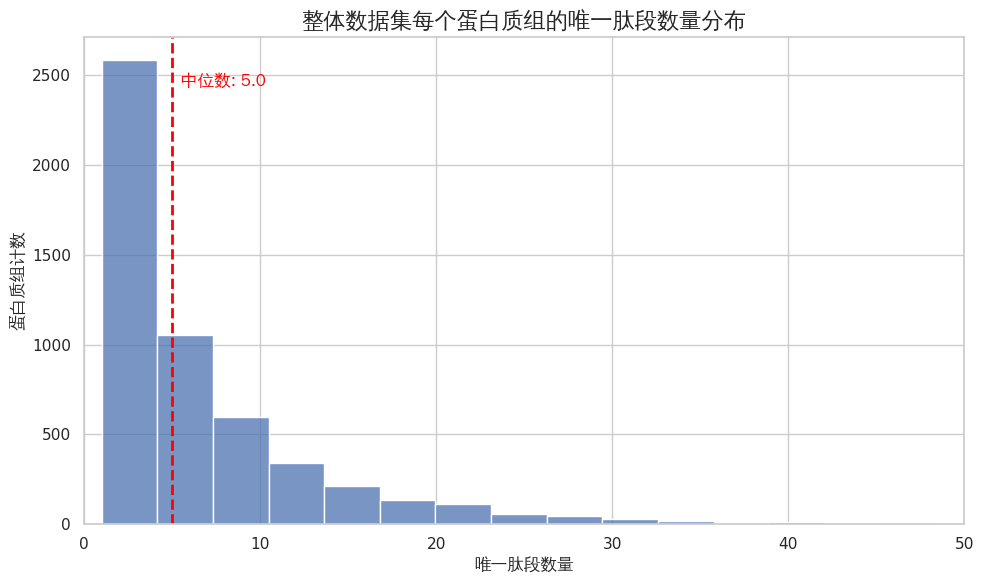


--- 3. 酶切效率 (漏切位点分析) ---
唯一肽段的漏切位点分布比例：


,PEP.NrOfMissedCleavages,Percentage (%)
0,0,74.155141
1,1,23.562570
2,2,2.282289


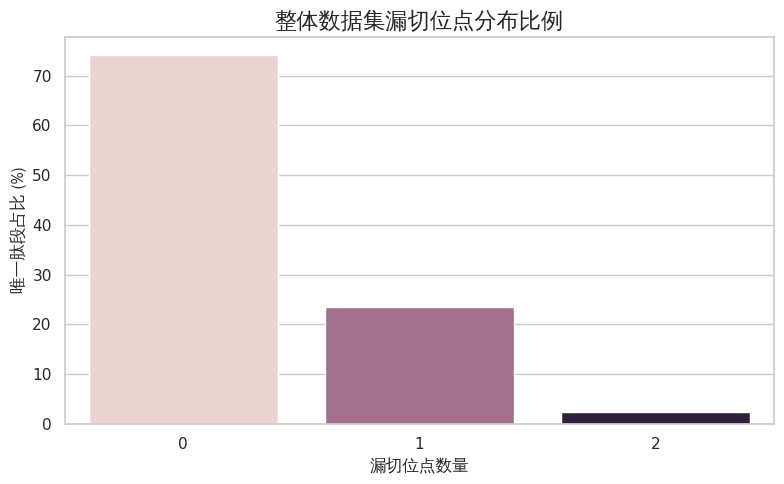


✅ 数据质量评估完成！

--- 数据质量摘要报告 ---
total_unique_proteins: 5228.00
total_unique_peptides: 36367.00
peptides_per_protein_median: 5.00
peptides_per_protein_mean: 6.96
percentage_0_missed_cleavages: 74.16


In [38]:
# 假设 df_filtered 是清洗后的总数据

# 调用“数据健康检查”函数
quality_report = evaluate_data_quality(
    dataframe=df_filtered,
    plot_title_prefix='整体数据集',
    language='ch'
)

# 打印出函数返回的摘要字典，方便记录
print("\n--- 数据质量摘要报告 ---")
for key, value in quality_report.items():
    print(f"{key}: {value:.2f}")